# Fandango Movie Ratings: Were They Being Inflated?

In October 2015, a data journalist named Walt Hickey has published [a work on Fandango's rating system](https://fivethirtyeight.com/features/fandango-movies-ratings/) on FiveThirtyEight. According to his analysis, [Fandango's website](https://www.fandango.com/), unlike the mobile apps, seemed to have rounded the ratings up in a way that could have been biased. Fandango later explained that the rounding disparity was a bug only found in the website.

If we take a closer look at [Walt Hickey's analysis](https://fivethirtyeight.com/features/fandango-movies-ratings/), we can see some examples how Fandango has been affected by this bug. For example, Fandango's "AggregateRating" schema states below that this Avengers movie has 5 complete stars:

![](https://fivethirtyeight.com/wp-content/uploads/2015/10/screen-shot-2015-10-12-at-2-36-08-pm.png?w=315)

However, Walt Hickey has found in the HTML of the page that this might not be the actual case - and he was right! Actual rating of the movie that is not rounded up can be seen here in the "ratingValue":

![](https://fivethirtyeight.com/wp-content/uploads/2015/10/screen-shot-2015-10-12-at-2-36-01-pm.png?w=575)

He has sampled 437 movies for his analysis. Some of his findings include that:
* 32% of the time, actual ratings of the movies were rounded up by the algorithm to the nearest half-star. For example, 3.2 stars would be rounded up to 3.5 stars instead of 3.
* About 8% of the ratings were rounded up to the nearest whole star. Like in the example above, we can see that 4.5 actual rating value of the movie was rounded up to 5.
* On one occasion, a rating was rounded up by an **entire** star from 4 to 5.

He has visualized the general case like below:

![](https://fivethirtyeight.com/wp-content/uploads/2015/10/hickey-datalab-fandango-3.png?w=575)

As we can see, both values are strongly left skewed. However, the ratings presented to users by Fandango's rounding algorithm seem to be more shifted to the right than those that weren't rounded, which might suggest that Fandango could have been inflating the ratings under the hood.

He also compared Fandango's ratings to other popular sites and visualized the results as below:

![](https://fivethirtyeight.com/wp-content/uploads/2015/10/hickey-datalab-fandango-2.png?w=575)

### Fandango's officials have stated that they have fixed this bug later on, to see if there's a truth to this, we'll be comparing Fandango's ratings for popular movies that were released in 2015 to those that were released in 2016.

To do this, we'll use the [data collected by one of Dataquest's team members](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/movie_ratings_16_17.csv) which includes movie ratings for movies released in 2016 and 2017 (after Hickey's analysis), as well as the [data Hickey collected](https://github.com/fivethirtyeight/data/tree/master/fandango) for his analysis.

# Let's begin with reading the data in:

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fandango_before = pd.read_csv("fandango_score_comparison.csv")
fandango_after = pd.read_csv("movie_ratings_16_17.csv")
fandango_before.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
fandango_after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


For now, we're interested in only the columns about Fandango's ratings. We'll isolate the variables we'll use:

In [4]:
before = fandango_before[["FILM", "Fandango_Stars", "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]].copy()
after = fandango_after[["movie", "year", "fandango"]].copy()
before.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [5]:
after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


### The columns we've isolated are explained below:
 * FILM/movie: Name of the movie in question.
 * Fandango_Stars: The number of stars the movie had on its Fandango movie page after the rounding.
 * Fandango_Ratingvalue: The number of stars the movie originally had before the rounding. 
 * Fandango_votes: Total amount of votes the movie had.
 * Fandango_Difference: The difference between the presented Fandango_Stars and the actual Fandango_Ratingvalue.
 * year: Release year of the movie.
 * fandango: Fandango user rating of the movie.
 
# Sampling the data according to our needs:

Our current populations of interest are Fandango's ratings for **popular** movies released in 2015 and 2016. Hickey's data contains only the movies with at least 30 fan reviews on Fandango. We'll be using this value to determine whether the data from 2016 is representative of the corresponding population or not. To do this, we'll generate a random sample using a [pseudorandom number generator](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) and check their amounts of fan reviews to see if they are popular, and therefore, representative of the population.

In [6]:
after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of 2020 July, Fandango's 5-Star Fan Ratings have been replaced with the Rotten Tomatoes Audience Score. Therefore, below are the amount of Fandango user ratings for these movies as of 2018 April acquired from another source:


| Movie	| Total Amount of Votes |
| :-: | :-: |
| Mechanic: Resurrection | 2247 |
| Warcraft | 7271 |
|Max Steel | 493 |
|Me Before You | 5263 |
|Fantastic Beasts and Where to Find Them | 13400 |
|Cell | 17 |
|Genius | 127 |
|Sully | 11877 |
|A Hologram for the King | 500 |
|Captain America: Civil War | 35057 |


As we can see, 90% of our sample of movies from 2016 is representative of its corresponding population.

In our next steps, we'll be isolating the movies by the years. As we've stated above, we'll only use movies released in 2015 and 2016.

In [7]:
after = after[after["year"] == 2016].copy()
after["year"].value_counts()

2016    191
Name: year, dtype: int64

In [8]:
before = before[before["FILM"].str[-5:-1] == "2015"].copy()
before["FILM"].str[-5:-1].value_counts()

2015    129
Name: FILM, dtype: int64

Now that we have prepared our data, we can start analyzing it.

# Comparing the distributions of movie ratings:

Now, we'll use Kernel Density Plots to plot each sample to compare them.

([<matplotlib.axis.XTick at 0x237ab6e7248>,
 <a list of 10 Text xticklabel objects>)

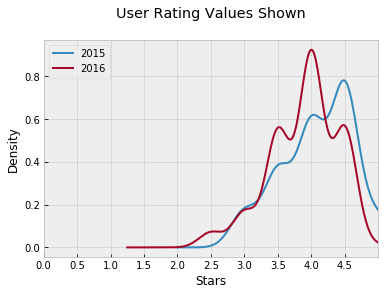

In [9]:
plt.style.use("bmh")
before["Fandango_Stars"].plot.kde(label="2015", legend=True)
after["fandango"].plot.kde(label="2016", legend=True)
plt.title("User Rating Values Shown\n")
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(np.arange(0,5.0,.5))

As we can see, both distributions are strongly negatively skewed, with distribution of values for 2015 shifted slightly to the right. What can be concluded from this is that there indeed is a difference between the two samples. According to the plot above, popular movies released in 2016 did rank lower than popular movies released in 2015.

### Let's see if this really is the case by comparing relative frequencies:

In [10]:
def freq_table_maker(series_obj):
    intervals = pd.interval_range(start=2, end=5, freq=0.5)
    freq_table = pd.Series([0,0,0,0,0,0], index=intervals)

    for star in series_obj:
        for interval in intervals:
            if star in interval:
                freq_table.loc[interval] += 1
                break
    
    freq_dist = round(freq_table / freq_table.sum() * 100, 2)
    return pd.DataFrame({'Percentile':freq_dist.values, 'Stars':freq_dist.index, })

print("Below are the distribution of stars for the year 2015:")
freq_table_maker(before["Fandango_Stars"])

Below are the distribution of stars for the year 2015:


,Percentile,Stars
0,0.00,"(2.0, 2.5]"
1,8.53,"(2.5, 3.0]"
2,17.83,"(3.0, 3.5]"
3,28.68,"(3.5, 4.0]"
4,37.98,"(4.0, 4.5]"
5,6.98,"(4.5, 5.0]"


In [11]:
print("Below are the distribution of stars for the year 2016:")
freq_table_maker(after["fandango"])

Below are the distribution of stars for the year 2016:


,Percentile,Stars
0,3.14,"(2.0, 2.5]"
1,7.33,"(2.5, 3.0]"
2,24.08,"(3.0, 3.5]"
3,40.31,"(3.5, 4.0]"
4,24.61,"(4.0, 4.5]"
5,0.52,"(4.5, 5.0]"


As we can see, the frequency distribution tables support our claims about the differences. 

### As a next step, we will be comparing summary statistics for both samples to see the direction of the difference more precisely:

We will compute mean, median and mode values for each sample and plot these on a grouped bar plot.

In [12]:
before["year"] = 2015
before.rename({"FILM": "movie",
               "Fandango_Stars": "fandango"}, axis=1, inplace=True)

before_and_after = pd.concat([after, before[["movie", "year", "fandango"]]], axis=0, ignore_index=True)

mean15 = before_and_after[before_and_after["year"] == 2015]["fandango"].agg(np.mean)
mean16 = before_and_after[before_and_after["year"] == 2016]["fandango"].agg(np.mean)
median15 = before_and_after[before_and_after["year"] == 2015]["fandango"].agg(np.median)
median16 = before_and_after[before_and_after["year"] == 2016]["fandango"].agg(np.median)
mode15 = before_and_after[before_and_after["year"] == 2015]["fandango"].mode()[0]
mode16 = before_and_after[before_and_after["year"] == 2016]["fandango"].mode()[0]

summary_stats = pd.DataFrame({"2015": [mean15, median15, mode15],
                              "2016": [mean16, median16, mode16]}, index=["mean", "median", "mode"])
summary_stats.head()

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


([<matplotlib.axis.XTick at 0x237ad064cc8>,
 <a list of 11 Text xticklabel objects>)

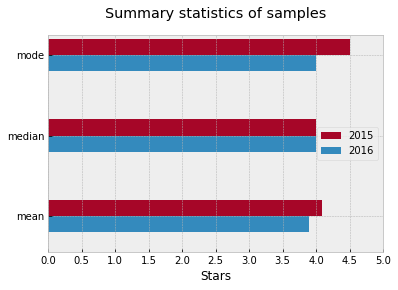

In [13]:
summary_stats["2015"].plot.barh(color="#a60628", position=0, legend=True, width=.20)
summary_stats["2016"].plot.barh(color="#348abd", position=1, legend=True, width=.20)
plt.title("Summary statistics of samples", y=1.05)
plt.xlim(0, 5)
plt.xlabel("Stars")
plt.xticks(np.arange(0,5.5,.5))

As we can see, there had been a decrease in the mean value by almost 0.2 stars from 2015 to 2016. While there's not a significant difference in the median values, mode value in 2016 seems to be lower, as well. These seem to support what we've previously concluded from Kernel Density Plots.

## In conlusion:
There is, indeed, a difference in ratings of popular movies between 2015 and 2016. What we've seen so far is that popular movies released in year 2016 has lower ratings than of those released in 2015. From this, we can conclude that the "bug" has been fixed and their rating system was no longer biased as of 2016.